#### Pendientes

In [174]:
#TODO 1: Revisar si las distribuciones vienen de una normal
#TODO 2: Revisar si estas diferencias son stadisticamente significativas
#TODO 3: Quitar las stopwords y revisar si se mantiene esta distribucion
#TODO 4: Si la distribucion no se mantiene, mantener pronombres en los stopwords.
#TODO 5: sacar caracteristicas TFIDF 
#TODO 6: Entrenar 3 modelos con esas caracteristicas XGBoost,LightGBM, Logistic Regression
#TODO 7: Sacar caracteristicas con BERT
#TODO 8: Entrenar 3 modelos con esas caracteristicas XGBoost,LightGBM, Logistic Regression
#TODO 9: realizar clasificacion explicita con 2 LLMs, pre-entrenadas y sin pre-entreno
#TODO 10: Comparar resultados

#### Config & Data ingestion

In [175]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from string import punctuation
import re
import statsmodels.api as sm 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [176]:
#Functions definition 

def remove_stopwords(text, stopwords):
    return " ".join([word for word in str(text).split() if word not in stopwords])

def remove_punctuation(text):
    return text.translate(str.maketrans('','', punctuation))



In [177]:
sns.set_theme(style ="ticks",context="paper", rc={'figure.figsize':(8,4)})


In [178]:
#Data Imports
data_path = Path(os.getcwd()).parent / "data"
train_path = data_path / "dreaddit-train.csv"
test_path = data_path / "dreaddit-test.csv"

train = pd.read_csv(train_path)
test =  pd.read_csv(test_path)
df = pd.concat([train,test]).reset_index(drop=True)

In [179]:

print(f"There are {df.shape[0]} entries")
print(f"Dataset have {df.shape[1]} features")

There are 3553 entries
Dataset have 116 features


There is a confirmation that labels are balanced


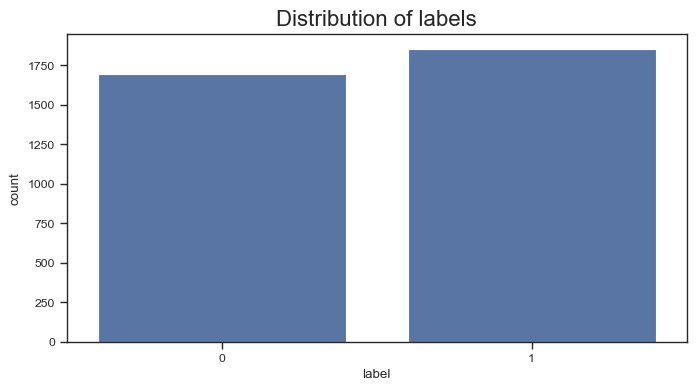

In [180]:
ax= sns.barplot(df.value_counts("label").reset_index(), x="label", y="count")
ax.set_title('Distribution of labels', fontsize=16)
print("There is a confirmation that labels are balanced")


#### Data Cleaning/ Initial Data wrangling


In [181]:

stop = set(stopwords.words('english'))

df["text"] = df.text.str.lower()
df["text_clean"] = df["text"].apply(remove_stopwords,args= (stop,)).apply(remove_punctuation)

#### **Uso de lenguage en singular entre los labels**

¿Los casos positivos para ansiedad tienen un mayor uso de pronombres en sigular?

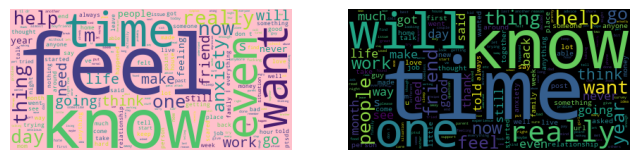

In [182]:
cloud_stress=WordCloud(background_color='pink',).generate(" ".join(df.query("label ==1").text.values))
cloud_noStress=WordCloud().generate(" ".join(df.query("label ==0").text.values))

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(cloud_stress)

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(cloud_noStress)

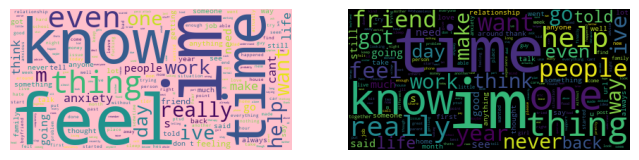

In [183]:
cloud_stress=WordCloud(background_color='pink',).generate(" ".join(df.query("label ==1").text_clean.values))
cloud_noStress=WordCloud().generate(" ".join(df.query("label ==0").text_clean.values))

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(cloud_stress)

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(cloud_noStress)

In [184]:
singular_pronouns = ["i ", "you", "he","she","it", "me", "him","her", "my","mine",
                     "your, yours", "his","her", "hers", "its","myself"]
plural_pronouns = ["we", "they", "us","them", "our", "ours", "their","theirs"]

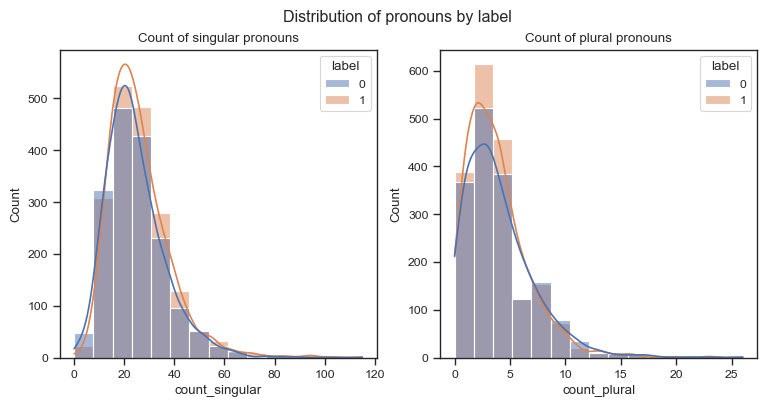

In [185]:
#Counts the number of singular and plural pronouns in each text
df["count_singular"] = 0
df["count_plural"] = 0

for t in singular_pronouns:
    df["count_singular"] +=df.text.str.count(t)

for t in plural_pronouns:
    df["count_plural"] += df.text.str.count(t)

fig, axes = plt.subplots(1,2, figsize=(9,4))
fig.suptitle("Distribution of pronouns by label")
ax1 = sns.histplot(df,x="count_singular", bins=15,hue="label", kde=True, ax=axes[0])
ax1.set_title("Count of singular pronouns")
ax2 =sns.histplot(df,x="count_plural", bins=15,hue="label", kde=True, ax=axes[1])
ax2.set_title("Count of plural pronouns");

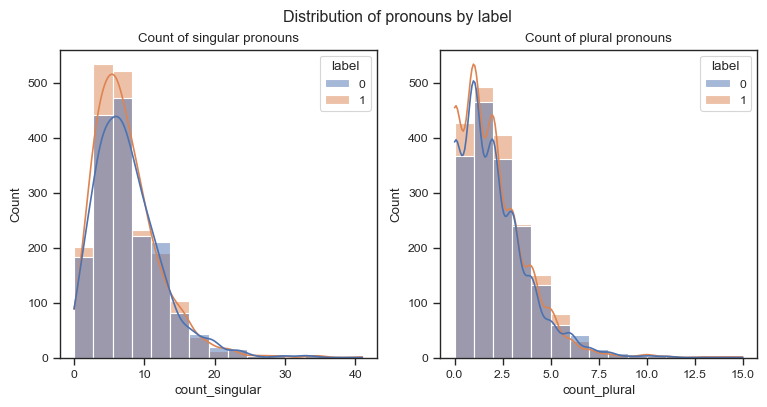

In [186]:

#Counts the number of singular and plural pronouns in each text (Preprocessed Text)
df["count_singular"] = 0
df["count_plural"] = 0

for t in singular_pronouns:
    df["count_singular"] +=df.text_clean.str.count(t)

for t in plural_pronouns:
    df["count_plural"] += df.text_clean.str.count(t)

fig, axes = plt.subplots(1,2, figsize=(9,4))
fig.suptitle("Distribution of pronouns by label")
ax1 = sns.histplot(df,x="count_singular", bins=15,hue="label", kde=True, ax=axes[0])
ax1.set_title("Count of singular pronouns")
ax2 =sns.histplot(df,x="count_plural", bins=15,hue="label", kde=True, ax=axes[1])
ax2.set_title("Count of plural pronouns");

En un principio parece ser que no son diferentes, sin embargo, es necesario realizar una prueba estadistica para confirmarlo.

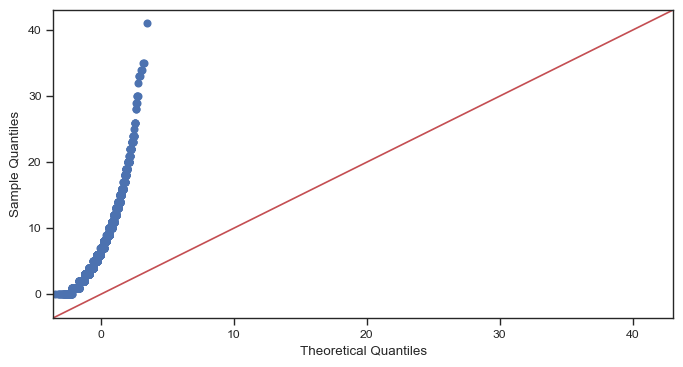

In [198]:

sm.qqplot(df.count_singular, line ='45');


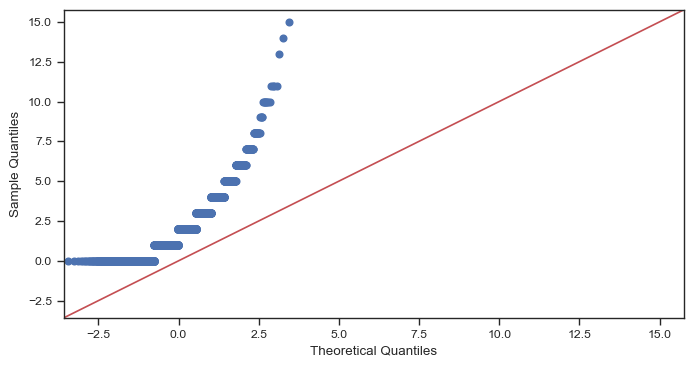

In [199]:
sm.qqplot(df.count_plural, line ='45');


Se comprueba que las distribuciones NO son normales, por lo tanto, se deben usar pruebas no paramétricas para compararlas, 